In [1]:
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
from modeler.modeler import Modeler as m
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
from modeler_strats.universal_modeler import UniversalModeler
import numpy as np
import matplotlib.pyplot as plt
import pickle
from functional.backtester import Backtester as b

In [2]:
start_date = datetime(2023,1,1)
end_date = datetime.now()

In [3]:
market = Market()
speculation_db = ADatabase("btc_spec")
classification_db = ADatabase("btc_spec_classification")
current_db = ADatabase("btc_current")
umod = UniversalModeler()

In [4]:
factors = [str(x) for x in range(14)]
included_columns=[
    "year",
    "week",
    "ticker",
    "adjclose",
    "y"
]
included_columns.extend(factors)

In [5]:
classification_factors = ["d1","d2","d3","rolling14"]
included_columns.extend(classification_factors)

In [6]:
trades = []
reqs = [0.15]
signals = [0.05,0.1,0.15]
values = [True,False]
classifications = [True,False]
ceilings = [True,False]
floors = [True,False]
hedges = [True,False]
parameters = []
positions = 1
training_year = 4
for value in values:
    for classification in classifications:
        for ceiling in ceilings:
            for floor in floors:
                for hedge in hedges:
                    for signal in signals:
                        for req in reqs:
                            parameter = {"value":value
                                         ,"classification":classification
                                         ,"ceiling":ceiling
                                         ,"floor":floor
                                         ,"hedge":hedge
                                         ,"signal":signal
                                         ,"req":req
                                         ,"training_years":training_year}
                            parameters.append(parameter)

In [7]:
training_sets = []
prices = pd.read_csv("./csv_files/prices/BTC-USD.csv")
prices = p.column_date_processing(prices)
prices["year"] = [x.year for x in prices["date"]]
prices["quarter"] = [x.quarter for x in prices["date"]]
ticker_data = prices
ticker_data.sort_values("date",ascending=True,inplace=True)
ticker_data["adjclose"] = [float(x) for x in ticker_data["adjclose"]]
ticker_data = ticker_data.groupby(["year","week"]).mean().reset_index()
for i in range(14):
    ticker_data[str(i)] = ticker_data["adjclose"].shift(i)
ticker_data["d1"] = ticker_data["adjclose"].pct_change(periods=1)
ticker_data["d2"] = ticker_data["d1"].pct_change(periods=1)
ticker_data["d3"] = ticker_data["d2"].pct_change(periods=1)
ticker_data["rolling14"] = ticker_data["adjclose"].rolling(window=14).mean()
ticker_data.dropna(inplace=True)
ticker_data["ticker"] = "BTC"
ticker_data["y"] = ticker_data["adjclose"].shift(-1)
ticker_data = ticker_data.replace([np.inf, -np.inf], np.nan).dropna()
ticker_data.dropna(inplace=True)
ticker_data = ticker_data[included_columns]
training_sets.append(ticker_data)
data = pd.concat(training_sets)
data = data.dropna()

In [8]:
prices = pd.read_csv("./csv_files/prices/BTC-USD.csv")
prices = p.column_date_processing(prices)
prices["year"] = [x.year for x in prices["date"]]
prices["week"] = [x.week for x in prices["date"]]
prices["quarter"] = [x.quarter for x in prices["date"]]
prices["ticker"] = "BTC"

In [9]:
prediction_slice = data[data["year"]==start_date.year].reset_index(drop=True)

In [10]:
speculation_db.connect()
models = speculation_db.retrieve("models")
speculation_db.disconnect()

In [11]:
simulation = umod.recommend(models,prediction_slice.copy(),factors)

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-03 11:19:38         2522
metadata.json                                  2023-03-03 11:19:38           64
variables.h5                                   2023-03-03 11:19:38        84160
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...metrics\mean_absolute_percentage_error
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
1/1 [==============================] - 0s 197ms/step


In [12]:
simulation["week"] = simulation["week"] + 1
simulation["prediction"] = (simulation["tf_prediction"] + simulation["cat_prediction"] + simulation["xgb_prediction"]) / 3

In [13]:
simulation[["year","week","adjclose","prediction"]]

,year,week,adjclose,prediction
0,2023,2,16866.642020,17158.707106
1,2023,3,19030.571987,19996.449682
2,2023,4,21754.474330,20104.040404
3,2023,5,23086.560268,20016.918694
4,2023,6,23273.128348,22275.391645
5,2023,7,22299.014230,22790.877728
6,2023,8,23642.106306,22737.405690
7,2023,9,23905.221819,22691.811745
8,2023,10,22991.969308,23702.151695
9,2023,11,21387.747489,22823.180811


In [14]:
classification_db.connect()
classification_models = classification_db.retrieve("models")
classification_db.disconnect()

In [15]:
classification_simulation = umod.recommend(classification_models,prediction_slice.copy(),classification_factors)
classification_simulation["week"] = classification_simulation["week"] + 1
classification_simulation["classification_prediction"] = ((classification_simulation["cat_prediction"] + \
                                                          classification_simulation["xgb_prediction"] + \
                                                          classification_simulation["tf_prediction"]) / 3) > 0.5

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-30 10:52:04         2149
metadata.json                                  2023-03-30 10:52:04           64
variables.h5                                   2023-03-30 10:52:04        23208
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dropout
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
.........8
...vars
1/1 [==============================] - 0s 44ms/step


In [16]:
for i in range(2,5):
    prices[f"return_{i}"] = (prices["adjclose"].shift(-i) - prices["adjclose"].shift(-1)) / prices["adjclose"].shift(-1)
price_returns = prices.fillna(0)

In [17]:
sim = price_returns.merge(simulation.drop("adjclose",axis=1),on=["year","week","ticker"],how="left") \
                    .merge(classification_simulation.drop("adjclose",axis=1),on=["year","week","ticker"],how="left")
sim["delta"] = (sim["prediction"] - sim["adjclose"]) / sim["adjclose"]

In [18]:
sim.dropna()[sim["date"]==datetime(2023,3,20)][["date","ticker","return_2","return_3","return_4"]]

,date,ticker,return_2,return_3,return_4
3106,2023-03-20,BTC,-0.03082,0.005613,-0.024224


In [19]:
sim

,date,open,high,low,close,adjclose,volume,year,quarter,week,...,d3_y,rolling14_y,xgb_prediction_y,xgb_score_y,cat_prediction_y,cat_score_y,tf_prediction_y,tf_score_y,classification_prediction,delta
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,2.105680e+07,2014,3,38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,3.448320e+07,2014,3,38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,3.791970e+07,2014,3,38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,3.686360e+07,2014,3,38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,2.658010e+07,2014,3,38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3126,2023-04-09,27952.367188,28532.830078,27828.480469,28333.050781,28333.050781,1.217532e+10,2023,2,14,...,0.439147,23158.630473,0.0,0.660377,0.0,0.811321,0.0,0.415094,False,-0.089896
3127,2023-04-10,28336.027344,29771.464844,28189.271484,29652.980469,29652.980469,1.928240e+10,2023,2,15,...,-0.325019,23421.384407,0.0,0.660377,0.0,0.811321,0.0,0.415094,False,-0.070270
3128,2023-04-11,29653.679688,30509.083984,29609.300781,30235.058594,30235.058594,2.012126e+10,2023,2,15,...,-0.325019,23421.384407,0.0,0.660377,0.0,0.811321,0.0,0.415094,False,-0.088169
3129,2023-04-12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,2023,2,15,...,-0.325019,23421.384407,0.0,0.660377,0.0,0.811321,0.0,0.415094,False,inf


In [20]:
current_db.connect()
current_db.drop("trades")
for parameter in tqdm(parameters):
    b.experimental_backtest(sim.copy(),parameter,start_date,end_date,current_db)
current_db.disconnect()

  2%|▏         | 2/96 [00:00<00:06, 14.08it/s]

btc_current trades documents must be a non-empty list
btc_current trades documents must be a non-empty list
btc_current trades documents must be a non-empty list


  6%|▋         | 6/96 [00:00<00:06, 13.88it/s]

btc_current trades documents must be a non-empty list
btc_current trades documents must be a non-empty list
btc_current trades documents must be a non-empty list
btc_current trades 

 10%|█         | 10/96 [00:00<00:06, 14.30it/s]

documents must be a non-empty list
btc_current trades documents must be a non-empty list
btc_current trades documents must be a non-empty list
btc_current trades documents must be a non-empty list


 12%|█▎        | 12/96 [00:00<00:05, 14.51it/s]

btc_current trades documents must be a non-empty list
btc_current trades documents must be a non-empty list
btc_current trades documents must be a non-empty list


 17%|█▋        | 16/96 [00:01<00:05, 14.37it/s]

btc_current trades documents must be a non-empty list
btc_current trades documents must be a non-empty list
btc_current trades documents must be a non-empty list


 21%|██        | 20/96 [00:01<00:05, 14.47it/s]

btc_current trades documents must be a non-empty list
btc_current trades documents must be a non-empty list
btc_current trades documents must be a non-empty list
btc_current trades documents must be a non-empty list


 23%|██▎       | 22/96 [00:01<00:05, 14.25it/s]

btc_current trades documents must be a non-empty list
btc_current trades documents must be a non-empty list
btc_current trades documents must be a non-empty list


 27%|██▋       | 26/96 [00:01<00:05, 13.73it/s]

btc_current trades documents must be a non-empty list
btc_current trades documents must be a non-empty list


 29%|██▉       | 28/96 [00:01<00:04, 13.80it/s]

btc_current trades documents must be a non-empty list
btc_current trades documents must be a non-empty list


 33%|███▎      | 32/96 [00:02<00:04, 14.15it/s]

btc_current trades documents must be a non-empty list
btc_current trades documents must be a non-empty list


 35%|███▌      | 34/96 [00:02<00:04, 14.19it/s]

btc_current trades documents must be a non-empty list
btc_current trades documents must be a non-empty list


 40%|███▉      | 38/96 [00:02<00:04, 14.42it/s]

btc_current trades documents must be a non-empty list
btc_current trades documents must be a non-empty list
btc_current trades documents must be a non-empty list


 44%|████▍     | 42/96 [00:02<00:03, 14.63it/s]

btc_current trades documents must be a non-empty list
btc_current trades documents must be a non-empty list


 48%|████▊     | 46/96 [00:03<00:03, 14.57it/s]

btc_current trades documents must be a non-empty list
btc_current trades documents must be a non-empty list
btc_current trades documents must be a non-empty list


 52%|█████▏    | 50/96 [00:03<00:03, 14.53it/s]

btc_current trades documents must be a non-empty list
btc_current trades documents must be a non-empty list


 58%|█████▊    | 56/96 [00:03<00:02, 14.39it/s]

btc_current trades documents must be a non-empty list


 60%|██████    | 58/96 [00:04<00:02, 13.96it/s]

btc_current trades documents must be a non-empty list


 65%|██████▍   | 62/96 [00:04<00:02, 14.15it/s]

btc_current trades documents must be a non-empty list


 67%|██████▋   | 64/96 [00:04<00:02, 13.58it/s]

btc_current trades documents must be a non-empty list


 71%|███████   | 68/96 [00:04<00:02, 12.40it/s]

btc_current trades documents must be a non-empty list


 73%|███████▎  | 70/96 [00:05<00:02, 11.94it/s]

btc_current trades documents must be a non-empty list


 75%|███████▌  | 72/96 [00:05<00:02, 11.36it/s]

btc_current trades documents must be a non-empty list


 79%|███████▉  | 76/96 [00:05<00:01, 10.67it/s]

btc_current trades documents must be a non-empty list


 83%|████████▎ | 80/96 [00:05<00:01, 10.93it/s]

btc_current trades documents must be a non-empty list


 85%|████████▌ | 82/96 [00:06<00:01, 10.80it/s]

btc_current trades documents must be a non-empty list


 90%|████████▉ | 86/96 [00:06<00:00, 10.90it/s]

btc_current trades documents must be a non-empty list


 92%|█████████▏| 88/96 [00:06<00:00, 11.45it/s]

btc_current trades documents must be a non-empty list


 96%|█████████▌| 92/96 [00:07<00:00, 10.96it/s]

btc_current trades documents must be a non-empty list


 98%|█████████▊| 94/96 [00:07<00:00, 10.90it/s]

btc_current trades documents must be a non-empty list


100%|██████████| 96/96 [00:07<00:00, 12.87it/s]

btc_current trades documents must be a non-empty list


In [21]:
current_db.connect()
t = current_db.retrieve("trades")
current_db.disconnect()

In [22]:
t = t.fillna(1)

In [23]:
analysis = []
for parameter in parameters:
    for position in range(positions):
        position_trades = t[(t["position"]==position)].sort_values(["year","week"])
        for key in parameter.keys():
            position_trades = position_trades[position_trades[key]==parameter[key]]
        initial = 100 / positions
        for delta in position_trades["actual_returns"]:
            initial = initial * (delta)
        if position_trades.index.size > 0:
            wr = position_trades[position_trades["actual_returns"]>0].index.size / position_trades.index.size
            analysis_dict = {}
            for key in parameter.keys():
                analysis_dict[key] = parameter[key]
            analysis_dict["position"]=position
            analysis_dict["wr"]=wr
            analysis_dict["pv"]=initial
            analysis.append(analysis_dict)
a = pd.DataFrame(analysis)

In [24]:
indexer = list(parameters[0].keys())
complete = a.pivot_table(index=indexer,columns="position",values="pv",fill_value=100/positions).reset_index()
complete["pv"] = [sum([row[1][i] for i in range(positions)]) for row in complete.iterrows()]
complete.sort_values("pv",ascending=False).head(10)

position,value,classification,ceiling,floor,hedge,signal,req,training_years,0,pv
4,False,False,False,True,False,0.05,0.15,4,112.761290,112.761290
12,False,False,True,True,False,0.05,0.15,4,112.761290,112.761290
0,False,False,False,False,False,0.05,0.15,4,112.681586,112.681586
8,False,False,True,False,False,0.05,0.15,4,112.681586,112.681586
28,False,True,True,True,False,0.05,0.15,4,108.643324,108.643324
24,False,True,True,False,False,0.05,0.15,4,108.643324,108.643324
16,False,True,False,False,False,0.05,0.15,4,108.643324,108.643324
20,False,True,False,True,False,0.05,0.15,4,108.643324,108.643324
6,False,False,False,True,True,0.05,0.15,4,105.148962,105.148962
14,False,False,True,True,True,0.05,0.15,4,105.148962,105.148962


In [25]:
top = complete.sort_values("pv",ascending=False).iloc[0]
analysis = t.copy()
for key in parameter.keys():
    analysis = analysis[(analysis[key]==top[key])]
ledger = analysis[["year","week","ticker","delta","actual_returns","position"]]

In [26]:
ledger.sort_values("week").tail(20)

,year,week,ticker,delta,actual_returns,position
106,2023,3,BTC,0.055418,1.071594,0
107,2023,4,BTC,0.123412,1.019537,0
108,2023,5,BTC,0.123608,1.013399,0
109,2023,8,BTC,0.084245,0.950000,0
110,2023,11,BTC,0.056797,1.108213,0
111,2023,12,BTC,0.089620,0.975776,0
112,2023,14,BTC,0.072119,0.991401,0
113,2023,15,BTC,0.070270,1.000000,0


In [27]:
metric = "position"

In [28]:
portfolio = ledger.pivot_table(index=["year","week"],columns="position",values="actual_returns").fillna(1).reset_index()
counted_columns = [x for x in range(ledger["position"].max()+1)]
for col in range(positions):
    if col not in counted_columns:
        portfolio[col] = 1
portfolio.reset_index()

position,index,year,week,0
0,0,2023,3,1.071594
1,1,2023,4,1.019537
2,2,2023,5,1.013399
3,3,2023,8,0.950000
4,4,2023,11,1.108213
5,5,2023,12,0.975776
6,6,2023,14,0.991401
7,7,2023,15,1.000000


In [29]:
counted_columns

[0]

In [30]:
cumulative = portfolio[[i for i in range(positions)]].cumprod()
cumulative["date_string"] = [f'{int(row[1]["year"])}-W{int(row[1]["week"])}' for row in portfolio.iterrows()]
cumulative["date"] = [datetime.strptime(x + '-1', '%G-W%V-%u') for x in cumulative["date_string"]]
cumulative["pv"] = [sum([row[1][column] * (100000 / positions) for column in range(positions)]) for row in cumulative.iterrows()]
cumulative

position,0,date_string,date,pv
0,1.071594,2023-W3,2023-01-16,107159.378138
1,1.092530,2023-W4,2023-01-23,109253.003342
2,1.107169,2023-W5,2023-01-30,110716.864538
3,1.051810,2023-W8,2023-02-20,105181.021311
4,1.165630,2023-W11,2023-03-13,116563.011467
5,1.137394,2023-W12,2023-03-20,113739.387946
6,1.127613,2023-W14,2023-04-03,112761.290197
7,1.127613,2023-W15,2023-04-10,112761.290197


In [31]:
cumulative

position,0,date_string,date,pv
0,1.071594,2023-W3,2023-01-16,107159.378138
1,1.092530,2023-W4,2023-01-23,109253.003342
2,1.107169,2023-W5,2023-01-30,110716.864538
3,1.051810,2023-W8,2023-02-20,105181.021311
4,1.165630,2023-W11,2023-03-13,116563.011467
5,1.137394,2023-W12,2023-03-20,113739.387946
6,1.127613,2023-W14,2023-04-03,112761.290197
7,1.127613,2023-W15,2023-04-10,112761.290197


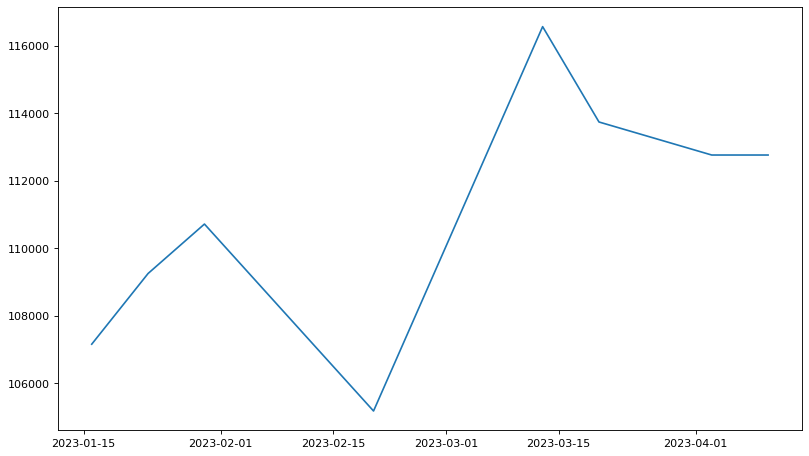

In [32]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])

In [33]:
sim[sim["date"]==sim["date"].max()].sort_values("delta",ascending=False).head(20)[["date","ticker","delta"]]

,date,ticker,delta
3130,2023-04-13,BTC,-0.084069
